In [ ]:
from functools import partial
import os
import tempfile
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler, HyperBandScheduler, AsyncHyperBandScheduler
import ray.cloudpickle as pickle


In [ ]:
def load_data(data_dir="./data"):
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(( 0.5), ( 0.5))]
    )
    # Applying transformations to the data to prevent overfitting
    transform_train = transforms.Compose([ # To fix overfitting 
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=3),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomRotation(5),  
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    trainset = torchvision.datasets.CIFAR100(
        root=data_dir, train=True, download=True, transform=transform_train
    )

    testset = torchvision.datasets.CIFAR100(
        root=data_dir, train=False, download=True, transform=transform
    )

    return trainset, testset

data = load_data()
data

Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR100
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                RandomCrop(size=(32, 32), padding=3)
                ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
                RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=0)
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ),
 Dataset CIFAR100
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=0.5, std=0.5)
            ))

In [3]:
trainset, testset_g = data


In [4]:
print(type(trainset.data))
print(type(trainset.targets))

<class 'numpy.ndarray'>
<class 'list'>


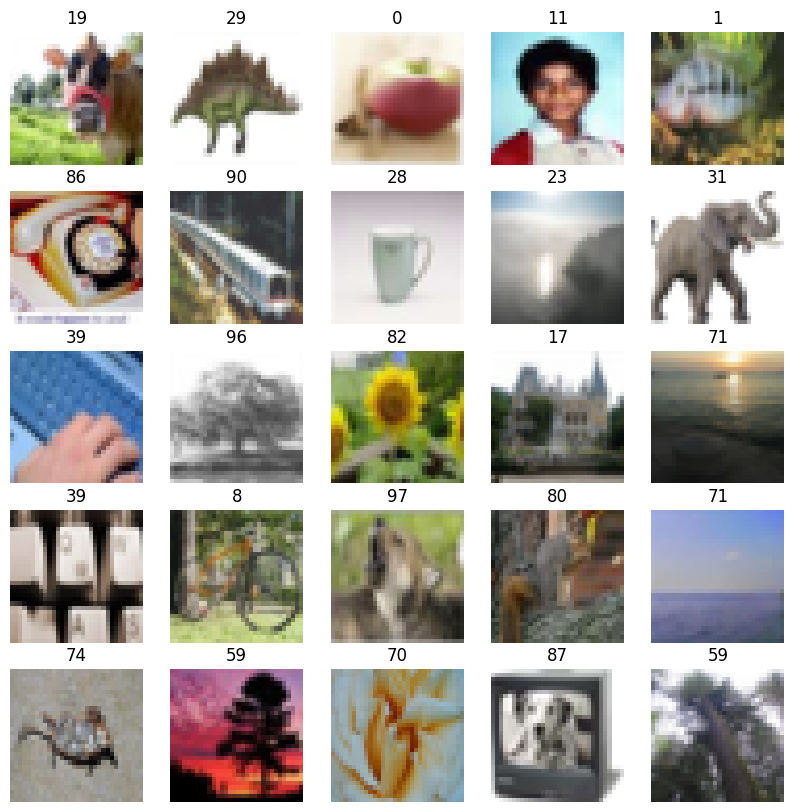

In [42]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):  
    ax.imshow(trainset.data[i])
    ax.title.set_text(trainset.targets[i])
    ax.axis("off")
plt.show()

In [34]:
trainset, testset_g = data


print(trainset.data.shape) # (50_000, 32, 32, 3)
print(len(trainset.targets)) # 50_000

(50000, 32, 32, 3)
50000


In [43]:
# Function to load coarse labels
def get_coarse_labels(file_path):
    with open(file_path, 'rb') as f:
        entry = pickle.load(f, encoding='latin1')
        coarse_labels = entry['coarse_labels']
    return coarse_labels

fine_labels = trainset.targets  # Fine labels are available directly
coarse_labels = get_coarse_labels('./data/cifar-100-python/train')  # Load coarse labels using the function

num_classes = len(set(fine_labels))
num_superclasses = len(set(coarse_labels))

print(f"number of classes (fine labels): {num_classes}")
print(f"number of superclasses (coarse labels): {num_superclasses}")
print(f"fine labels sample: {fine_labels[:10]}")
print(f"coarse labels sample: {coarse_labels[:10]}")

number of classes (fine labels): 100
number of superclasses (coarse labels): 20
fine labels sample: [19, 29, 0, 11, 1, 86, 90, 28, 23, 31]
coarse labels sample: [11, 15, 4, 14, 1, 5, 18, 3, 10, 11]


In [7]:
for fine_label in set(fine_labels):
    assert trainset.targets.count(fine_label) == 500 # 500 training images for each class 
    assert testset_g.targets.count(fine_label) == 100 # 100 test images 


# Dividing the dataset
- The dataset already comes divided in training and test dataset. 
- To farder divide the dataset into sub_train and validation, I use the random_split function from pytorch. 
- To the random split function I feed in the entire trainset and legnths of the training set and validation set. 
- In this case we want the validation set to be 1/5 of the training data set.
- Since our entire data is 50,000 images, the validation set is 10,000 and the sub_train is 40,000.  

### Coming up with the specific trainig split

In [ ]:
# - The dataset already comes divided in training and test dataset. 
# - To furder divide the dataset into sub_train and validation, I use the random_split function from pytorch. 
# - To the random split function I feed in the entire trainset and lengths of the training set and validation set. 
# - In this case we want the validation set to be 1/5 of the training data set.
# - Since our entire data is 50,000 images, the validation set is 10,000 and the sub_train is 40,000.  

len_val_set = len(trainset) // 5 # 1/5 of trainig set 
print(f"len_val_set= {len_val_set}")

len_trainig_set = len(trainset) - len_val_set
print(f"len_trainig_set= {len_trainig_set}")

len_val_set= 10000
len_trainig_set= 40000


### Splitting using random split function

In [ ]:
sub_train_g , valid_g  = random_split(dataset=trainset, lengths=[ len_trainig_set,  len_val_set]) 
# Print the first image
import ray 
ray.init(ignore_reinit_error=True)
# Putting the data on the object to pay to ray tune. The the other methods would cause a crash. 
sub_train_ray = ray.put(sub_train_g)
valid_ray = ray.put(valid_g)
test_ray = ray.put(testset_g)

2024-11-15 08:17:14,799	WARNING services.py:2022 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=8.19gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-11-15 08:17:15,993	INFO worker.py:1819 -- Started a local Ray instance.


(raylet) [2024-11-15 08:18:15,957 E 2477 2477] (raylet) node_manager.cc:3069: 3 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 59a12cb379878fae93bfa231d442e7300d46b289189562d93e18c07e, IP: 172.18.0.2) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.18.0.2`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(raylet) [2024-11-15 08:20:15,961 E 2477 2477] (raylet) node_manager.cc:3069: 2 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 59a12cb379878fae93bfa231d442e7300d46b289189562d93e18c07e, IP: 172.18.0.2) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.18.0.2`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


# Selecting the model

First I make 8 different CNN models, along with different configuration, and use ray tune to collect the 3 best models. 
I configure ray tune to run 16 models parallel ( async ) and keep the 50% of the best models as it runs. 
At the end I just collect the 3 best configurations, and further retrain the 3 selected models with the entire training set. 



$$ [ \text{Output Size} = \left\lfloor \frac{\text{Input Size} + 2 \times \text{Padding} - \text{Kernel Size}}{\text{Stride}} \right\rfloor + 1 ] $$




### 8 Different CNN Configurations 

In [ ]:
def calcualte_output_size(input_size:int, kernel_size:int, stride:int, padding:int):
    return ((input_size + 2*padding - kernel_size)//stride) + 1

class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        # 32x32x3 images
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=3, padding=1),  # Output:  (( 32 + 2*(1) - 3  ) )/1 + 1 =  32 x 32 x 64
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.Conv2d(48, 100, kernel_size=3, padding=1),  # Output:  (( 32 + 2*(1) - 3  ) )/1 + 1 =   32 x 32 x 64
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)  #  Output:  (( 32 + (2*0) - 2 )/2 ) + 1 =  16 x 16 x 64
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(100, 128, kernel_size=3, padding=1),  #  output : ((16 + 2*(1) - 3  ) ) /1 + 1 =  16 x 16 x 128
            nn.ReLU(),
            nn.Conv2d(128, 200, kernel_size=3, padding=1),   # output : ((16 + 2*(1) - 3  ) ) /1 + 1 =  16 x 16 x  128
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (( 16 + (2*0) - 2 )/2 ) + 1 =  8 x 8 x 128
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(200, 256, kernel_size=3, padding=1),  # outut: ((8 + 2*(1) - 3  ) ) /1 + 1 =  8 x 8 x 256
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (( 8 + (2*0) - 2 )/2 ) + 1 =  4 x 4 x 256
            nn.Dropout(0.2)
        )
        self.fc = nn.Sequential( 
            nn.Linear(4 * 4 * 256, 150),  
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(150, 100)  # 100 classes
        ) 
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc(out)
        return out    
    
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()# 32x32x3 images 
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # 1 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),# 2  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # Output: 16x16 # 3 
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 150, kernel_size=3, padding=1), # output: ((16 + 2*(1) - 3  ) ) /1 + 1 =  16 x 16 x 128
            nn.BatchNorm2d(150), 
            nn.ReLU(),
            nn.Conv2d(150, 300, kernel_size=3, padding=1), # output: ((16 + 2*(1) - 3  ) ) /1 + 1 =  16 x 16 x  128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # output : (( 16 + (2*0) - 2 )/2 ) + 1 =  8 x 8 x 128s
        )
        self.fc = nn.Sequential(
            nn.Linear(8 * 8 * 300, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 100)  # 100 classes
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc(out)
        return out
    
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
        )
        layer1_output_size = calcualte_output_size(input_size=32, kernel_size=7, stride=1, padding=1)
        layer1_output_size = calcualte_output_size(input_size=layer1_output_size, kernel_size=2, stride=2, padding=0)
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=150, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(150),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
        )
        layer2_output_size = calcualte_output_size(input_size=layer1_output_size, kernel_size=3, stride=1, padding=1)
        layer2_output_size = calcualte_output_size(input_size=layer2_output_size, kernel_size=2, stride=2, padding=0)
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=150, out_channels=200, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Dropout(0.1) 
        )
        layer3_output_size = calcualte_output_size(input_size=layer2_output_size, kernel_size=3, stride=1, padding=1)
        layer3_output_size = calcualte_output_size(input_size=layer3_output_size, kernel_size=2, stride=2, padding=0)
        # print(f"cnn3 layer3_output_size= {layer3_output_size}")
        self.fc = nn.Sequential(
            nn.Linear(layer3_output_size * layer3_output_size*200, 256, bias=True),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 100),
        )
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    

class CNN4(nn.Module):
    def __init__(self):
        super(CNN4, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2), 
        )
        layer1_output_size = calcualte_output_size(input_size=32, kernel_size=5, stride=1, padding=1)
        layer1_output_size = calcualte_output_size(input_size=layer1_output_size, kernel_size=2, stride=2, padding=0)
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=132, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(132),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Dropout(0.1)
        )
        layer2_output_size = calcualte_output_size(input_size=layer1_output_size, kernel_size=3, stride=1, padding=1)
        layer2_output_size = calcualte_output_size(input_size=layer2_output_size, kernel_size=2, stride=2, padding=0)
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=132, out_channels=256, kernel_size=2, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2), 
            nn.Dropout(0.1)
        )
        layer3_output_size = calcualte_output_size(input_size=layer2_output_size, kernel_size=2, stride=1, padding=1)
        layer3_output_size = calcualte_output_size(input_size=layer3_output_size, kernel_size=2, stride=2, padding=0)
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=200, kernel_size=1, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.1)
        )
        layer5_output_size = calcualte_output_size(input_size=layer3_output_size, kernel_size=1, stride=1, padding=1)
        layer5_output_size = calcualte_output_size(input_size=layer5_output_size, kernel_size=2, stride=2, padding=0)
        self.fc = nn.Sequential(
            nn.Linear(layer5_output_size*layer5_output_size*200, 128, bias=True),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 100),
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
class CNN5(nn.Module): # GOOD MODEL
    def __init__(self):
        super(CNN5, self).__init__()  # Input: 32x32x3 images
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=2, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces to 16x16
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces to 8x8
        )
        self.fc = nn.Linear(8*8*128, 100, bias=True)  # 4,096 input features

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc(out)
        return out

class CNN6(nn.Module): # GOOD MODEL 
    def __init__(self):
        super(CNN6, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 246, kernel_size=3, padding=1),
            nn.BatchNorm2d(246),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(246, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.fc = nn.Linear(8*8*256, 100)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

class CNN7(nn.Module): # GOOD MODEL 
    def __init__(self):
        super(CNN7, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 38, kernel_size=3, padding=1),
            nn.BatchNorm2d(38),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)  
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(38, 255, kernel_size=3, padding=1),
            nn.BatchNorm2d(255),
            nn.LeakyReLU(0.1), 
            nn.Dropout(0.1) 
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(255, 399, kernel_size=3, padding=1),
            nn.BatchNorm2d(399),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1) 
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(399, 200, kernel_size=3, padding=1),
            nn.BatchNorm2d(200),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1)  
        )
        self.fc = nn.Linear(8*8*200, 100)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

class CNN8(nn.Module):
    def __init__(self):
        super(CNN8, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        layer1_size = calcualte_output_size(input_size=32, kernel_size=5, stride=1, padding=1)
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        layer2_size = calcualte_output_size(input_size=layer1_size, kernel_size=4, stride=1, padding=1)
        layer2_size = calcualte_output_size(input_size=layer2_size, kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.1)  
        )
        layer3_size = calcualte_output_size(input_size=layer2_size, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1)  
        )
        layer4_size = calcualte_output_size(input_size=layer3_size, kernel_size=2, stride=1, padding=1)
        layer4_size = calcualte_output_size(input_size=layer4_size, kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Sequential( 
        nn.Linear( layer4_size*layer4_size*256, 256),
        nn.LeakyReLU(0.05),
        nn.Dropout(0.2),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 100)
        )
        
        
        

    def forward(self, x):
        out = self.conv1(x)
        identity = out
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = out.view(out.size(0), -1)
        out = F.leaky_relu(self.fc1(out))
        return out

# TO CHECK THE THE OUTPUT SHAPE OF THE MODELS
sample_input = torch.randn(1, 3, 32, 32)  # Batch size of 1, 3 color channels, 32x32 image
for idx, model in enumerate( [CNN1(), CNN2(), CNN3(), CNN4(), CNN5(), CNN6(), CNN7(), CNN8()], 1):
    print(f"CNN{idx}")
    output = model(sample_input)
    print(f" output shape: {output.shape}")


CNN1
 output shape: torch.Size([1, 100])
CNN2
 output shape: torch.Size([1, 100])
CNN3
 output shape: torch.Size([1, 100])
CNN4
 output shape: torch.Size([1, 100])
CNN5
 output shape: torch.Size([1, 100])
CNN6
 output shape: torch.Size([1, 100])
CNN7
 output shape: torch.Size([1, 100])
CNN8
 output shape: torch.Size([1, 100])


In [11]:
import torch

if torch.cuda.is_available():
    device = 'cuda' # gpu
elif torch.backends.mps.is_available():
    device = 'mps' # macos
else:
    device = 'cpu' # cpu

print(f"Using device: {device}")

Using device: cuda


### Different optimzers and hyperparametes

In [12]:
from typing import Dict, Type 


models :Dict[str, Type[nn.Module] ] = {
    "CNN1": CNN1,
    "CNN2": CNN2,
    "CNN3": CNN3,
    "CNN4": CNN4,
    "CNN5": CNN5,
    "CNN6": CNN6,
    "CNN7": CNN7,
    "CNN8": CNN8,
}


config = {
    "model": tune.choice(list(models.keys())),
    "optimizer": tune.choice(["Adam", "RMSProp", "AdaGrad", "SGD"]),
    "Adam": {
        "lr":  tune.uniform(1e-4, 1e-1),
        "B1": tune.uniform(0.8, 0.99999), # (0.9, 0.999),
        "B2" : tune.uniform(0.8, 0.99999999),
    },
    "RMSProp":{
        "lr": tune.loguniform(1e-4, 1e-1),
        "alpha": tune.uniform(0.8, 1),
        "momentum" : tune.uniform(0, 0.5),
    },
    "AdaGrad": {
        "lr": tune.loguniform(1e-3, 1e-1),
        "initial_accumulator_value": tune.uniform(0.0, 0.3),
        "lr_decay" : tune.uniform( 0, 0.1),
    },
    "SGD":  {
        "lr": tune.loguniform(1e-5, 0.1),
        "momentum": tune.uniform(0.0, 0.4),
        "dampening" : tune.uniform(0, 0.4),
    }
}


In [ ]:
import pprint
from typing import List, Literal
from torch.utils.data import DataLoader
import logging

# Or more broadly for all ray components:
ray.logger.setLevel(logging.INFO)

def train_cifar(config, checkpoint_dir=None, all_training_data=None, max_epochs=10000000 ):
    '''THis function is used by ray tune to select the model, but also is used to train the best models entirely from the training data.'''
    print(pprint.pformat(config))
    net = models[config["model"]]().to(device)

    criterion = nn.CrossEntropyLoss() # Multiclass Loss Function 
    
    if config["optimizer"] == "Adam": #  γ,β1,β2
        # I assumed when a optimizer is passed the correct kkkey values for the config are also passed.
        optimizer = optim.Adam(net.parameters(), lr=config['Adam']["lr"], betas=(config['Adam']["B1"], config['Adam']["B2"]))
    elif config["optimizer"] == "RMSProp": # α,γ,µ
        optimizer = optim.RMSprop(net.parameters(), lr=config['RMSProp']["lr"], alpha=config['RMSProp']["alpha"], momentum=config['RMSProp']["momentum"])
    elif config["optimizer"] == "AdaGrad": # γ,τ,η
        optimizer = optim.Adagrad(net.parameters(), lr=config['AdaGrad']["lr"], initial_accumulator_value=config['AdaGrad']["initial_accumulator_value"], lr_decay=config['AdaGrad']["lr_decay"])
    else: # SDG γ,µ,τ
        optimizer = optim.SGD(net.parameters(), lr=config['SGD']["lr"], momentum=config['SGD']["momentum"], dampening=config['SGD']["dampening"])

    # Load checkpoint, This would happen if I train from a previous trained time ( will start ahead ). 
    if checkpoint_dir:
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                checkpoint = pickle.load(fp)
        net.load_state_dict(checkpoint["net_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint["epoch"] + 1
        avg_train_loss = checkpoint["train_loss_array"]
        avg_val_loss = checkpoint["val_loss_array"]
        print("Resuming from checkpoint")
    else:
        start_epoch = 0
        avg_train_loss: List[float] = []
        avg_val_loss: List[float] = []


    train_subset = ray.get(sub_train_ray) # Get the data from the ray tune object 
    val_subset = ray.get(valid_ray)
    
    trainloader = DataLoader(
        train_subset, batch_size=8, shuffle=True, num_workers=2,  #prefetch_factor=4 # type: ignore
    ) if all_training_data is None else DataLoader( # if training data is passes ( when function is by myself instead of ray tune ( I pass the entire training data))
        all_training_data, batch_size=100, shuffle=True, num_workers=2,  prefetch_factor=4 # type: ignore
    )
    valloader = DataLoader(
        val_subset, batch_size=8, shuffle=True, num_workers=2 # type: ignore
    ) if all_training_data is None else (0, 0) # No validation data
    
    avg_train_loss : List[float] = []
    avg_val_loss : List[float] = []
    
    for epoch in range(max_epochs): # while true 
        running_loss = 0.0
        epoch_steps = 0
        net.train() # Set model to training mode
        for i, data in enumerate(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
        # print(f"avg_train_loss = {running_loss / epoch_steps}")
        avg_train_loss_v = float(running_loss / epoch_steps)
        avg_train_loss.append(avg_train_loss_v)
        
        if all_training_data is not None:
            print(f"Epoch: {epoch}, avg_train_loss: {avg_train_loss_v}")
            continue # Skip validation, tune report and checkpointing
        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        net.eval() # Set model to evaluation mode
        for i, data in enumerate(valloader):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1
        avg_val_loss_v = float(val_loss / val_steps)
        # print(f"avg_val_loss_v = {avg_val_loss_v}")
        avg_val_loss.append(avg_val_loss_v)
        
        # Save information about the model
        checkpoint_data = {
            "epoch": epoch,
            "net_state_dict": net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_loss_array": [float(v) for v in avg_val_loss], 
            "train_loss_array": [float(v) for v in avg_train_loss]
        }
        with tempfile.TemporaryDirectory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "wb") as fp:
                pickle.dump(checkpoint_data, fp) # type: ignore

            checkpoint = Checkpoint.from_directory(checkpoint_dir)
            # Report how the model is perfoming
            train.report(
                {"loss": avg_val_loss_v, 
                 "accuracy": correct / total, 
                 "train_loss": avg_train_loss_v,
                 },
                checkpoint=checkpoint,
            )

    print("Finished Training")
    if all_training_data is not None:
        return avg_train_loss, net
    


In [ ]:
def test_accuracy(net : nn.Module ):
    '''Function to tets the accuracy of a model'''
    testloader = DataLoader( # Make data ready for model ( load ) 
        testset_g, batch_size=1028, shuffle=False, num_workers=2
    )

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images).to(device)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total


### Using Ray tune make up 60 different combinations and run 16 trials parally ( concunrently  )

In [ ]:


def train_multiple(config:dict,  num_samples:int=60, max_num_epochs:int=30,  ):
    scheduler = AsyncHyperBandScheduler(
        metric="accuracy",
        mode="max", # Testing for best accuracy 
        max_t=max_num_epochs,
        grace_period=1, # Will remove trials until after 1 epoch
        reduction_factor=2, # 1/2= 0.5 or 50% of the trials will continue 
    )
    return tune.run(
        partial(train_cifar),
        resources_per_trial={"cpu": 1, "gpu": 0.06},  # Should attempt to run 1/0.06= 16 trials concurrently
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        verbose=2,  # 0 = silent, 1 = default, 2 = verbose.
        log_to_file=True,
        # fail_fast=True, # Stop once a trial fails
        resume=True, 
    )

analysis = train_multiple(config) 


2024-11-15 08:30:12,079	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2024-11-15 08:30:12,130	ERROR tune_controller.py:235 -- Failed to restore the run state.
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/ray/tune/execution/tune_controller.py", line 230, in __init__
    self.resume(resume_config=resume_config)
  File "/usr/local/lib/python3.9/site-packages/ray/tune/execution/tune_controller.py", line 437, in resume
    raise ValueError(
ValueError: Tried to resume experiment from directory '/root/ray_results/train_cifar_2024-11-15_08-30-12', but no experiment state file of the form 'experiment_state-{}.json' was found. This is expected if you are launching a new experiment.
2024-11-15 08:30:12,133	INFO tune_controller.py:238 -- Restarting experiment.


(func pid=22318) {'AdaGrad': {'initial_accumulator_value': 0.2194112345839562,
(func pid=22318)              'lr': 0.04692402094825924,
(func pid=22318)              'lr_decay': 0.07181905950045835},
(func pid=22318)  'Adam': {'B1': 0.8549288062778276,
(func pid=22318)           'B2': 0.8976972964335019,
(func pid=22318)           'lr': 0.05851855790894521},
(func pid=22318)  'RMSProp': {'alpha': 0.8281342188885182,
(func pid=22318)              'lr': 0.06106809975398345,
(func pid=22318)              'momentum': 0.26497509372872363},
(func pid=22318)  'SGD': {'dampening': 0.22460717660136642,
(func pid=22318)          'lr': 0.0006472687400617106,
(func pid=22318)          'momentum': 0.24158426402884678},
(func pid=22318)  'model': 'CNN5',
(func pid=22318)  'optimizer': 'RMSProp'}
(func pid=22319)           'B2': 0.8961233514128357,
(func pid=22319)  'optimizer': 'Adam'}
(func pid=22317)           'B2': 0.9615879324103922,
(func pid=22317)  'optimizer': 'SGD'}
(func pid=22316)        

Trial name,accuracy,loss,should_checkpoint,train_loss
train_cifar_d4d14_00000,0.0103,4.74858,True,5.61992
train_cifar_d4d14_00001,0.0076,4.77166,True,5.77504
train_cifar_d4d14_00002,0.0775,4.19346,True,4.30292
train_cifar_d4d14_00003,0.2893,2.9748,True,3.19261
train_cifar_d4d14_00004,0.0104,4.85874,True,5.76123
train_cifar_d4d14_00005,0.5329,1.9141,True,1.30661
train_cifar_d4d14_00006,0.4889,1.96921,True,1.66697
train_cifar_d4d14_00007,0.098,4.69853,True,4.61207
train_cifar_d4d14_00008,0.0102,4.63141,True,4.83756
train_cifar_d4d14_00009,0.1123,3.78554,True,4.01254


(func pid=22325) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00014_14_initial_accumulator_value=0.1681,lr=0.0299,lr_decay=0.0963,B1=0.8847,B2=0.8604,lr=0.0407,alpha=0.8874,l_2024-11-15_08-30-12/checkpoint_000000)
(func pid=22318) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00001_1_initial_accumulator_value=0.2194,lr=0.0469,lr_decay=0.0718,B1=0.8549,B2=0.8977,lr=0.0585,alpha=0.8281,lr_2024-11-15_08-30-12/checkpoint_000000) [repeated 2x across cluster]


(func pid=26489)           'B2': 0.9889057525563342,
(func pid=26489) {'AdaGrad': {'initial_accumulator_value': 0.15637833471274568, [repeated 16x across cluster]
(func pid=26489)          'lr': 0.00021484011185049054, [repeated 64x across cluster]
(func pid=26489)              'lr_decay': 0.038910215654939344}, [repeated 16x across cluster]
(func pid=26489)  'Adam': {'B1': 0.8739259602189171, [repeated 16x across cluster]
(func pid=26489)  'RMSProp': {'alpha': 0.887894436691082, [repeated 16x across cluster]
(func pid=26489)          'momentum': 0.07828862951733379}, [repeated 32x across cluster]
(func pid=26489)  'SGD': {'dampening': 0.031159646738025605, [repeated 16x across cluster]
(func pid=26489)  'model': 'CNN7', [repeated 16x across cluster]
(func pid=22321)  'optimizer': 'RMSProp'}
(func pid=22330)  'optimizer': 'Adam'} [repeated 5x across cluster]
(func pid=26489)  'optimizer': 'SGD'} [repeated 7x across cluster]
(func pid=26601)           'B2': 0.921077259146474,
(func pid=

(func pid=22324) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00010_10_initial_accumulator_value=0.0332,lr=0.0071,lr_decay=0.0191,B1=0.9207,B2=0.9991,lr=0.0764,alpha=0.9503,l_2024-11-15_08-30-12/checkpoint_000000)
(func pid=22330) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00015_15_initial_accumulator_value=0.1519,lr=0.0095,lr_decay=0.0332,B1=0.9111,B2=0.9659,lr=0.0810,alpha=0.9897,l_2024-11-15_08-30-12/checkpoint_000000)


(func pid=27273) {'AdaGrad': {'initial_accumulator_value': 0.1693492449271744,
(func pid=27273)              'lr_decay': 0.014741125667307231},
(func pid=27273)  'Adam': {'B1': 0.8603218933155744,
(func pid=27273)           'B2': 0.8792262911019656,
(func pid=27273)  'RMSProp': {'alpha': 0.9875977152251811,
(func pid=27273)  'SGD': {'dampening': 0.13615042319162396,
(func pid=27273)  'model': 'CNN7',
(func pid=27273)  'optimizer': 'AdaGrad'}
(func pid=27273)          'lr': 0.02233612837440832, [repeated 4x across cluster]
(func pid=27273)          'momentum': 0.16239758230954654}, [repeated 2x across cluster]


(func pid=22322) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00009_9_initial_accumulator_value=0.2608,lr=0.0102,lr_decay=0.0960,B1=0.8296,B2=0.9945,lr=0.0610,alpha=0.9253,lr_2024-11-15_08-30-12/checkpoint_000000) [repeated 2x across cluster]


(func pid=27348)           'B2': 0.8278158121709699,
(func pid=27348)  'optimizer': 'AdaGrad'}


(func pid=22320) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00004_4_initial_accumulator_value=0.1907,lr=0.0023,lr_decay=0.0046,B1=0.8983,B2=0.8233,lr=0.0578,alpha=0.9892,lr_2024-11-15_08-30-12/checkpoint_000000) [repeated 2x across cluster]


(func pid=27716)           'B2': 0.9964580434703536,
(func pid=27716)  'optimizer': 'SGD'}
(func pid=27716) {'AdaGrad': {'initial_accumulator_value': 0.259904855105395, [repeated 2x across cluster]
(func pid=27716)              'lr_decay': 0.06281191469048562}, [repeated 2x across cluster]
(func pid=27716)  'Adam': {'B1': 0.9772984099555387, [repeated 2x across cluster]
(func pid=27716)  'RMSProp': {'alpha': 0.856085614356171, [repeated 2x across cluster]
(func pid=27716)  'SGD': {'dampening': 0.11794488155327465, [repeated 2x across cluster]
(func pid=27716)  'model': 'CNN1', [repeated 2x across cluster]
(func pid=27716)          'lr': 1.9851619520299803e-05, [repeated 8x across cluster]
(func pid=27716)          'momentum': 0.21540090626280417}, [repeated 4x across cluster]
(func pid=27857)           'B2': 0.9656079304866152,
(func pid=27857)  'optimizer': 'AdaGrad'}
(func pid=27857) {'AdaGrad': {'initial_accumulator_value': 0.0006998833279765803,
(func pid=27857)              'lr_de

(func pid=22317) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00005_5_initial_accumulator_value=0.1615,lr=0.0065,lr_decay=0.0052,B1=0.8139,B2=0.9616,lr=0.0579,alpha=0.8311,lr_2024-11-15_08-30-12/checkpoint_000000) [repeated 2x across cluster]
(func pid=22321) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00011_11_initial_accumulator_value=0.0584,lr=0.0019,lr_decay=0.0559,B1=0.8538,B2=0.8672,lr=0.0833,alpha=0.9870,l_2024-11-15_08-30-12/checkpoint_000000)
(func pid=22323) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00003_3_initial_accumulator_value=0.1229,lr=0.0238,lr_decay=0.0815,B1=0.9407,B2=0.9068,lr=0.0003,alpha=0.8163,lr_2024-11-15_08-30-12/checkpoint_000000)


(func pid=28685)           'B2': 0.8473840839746845,
(func pid=28685)  'optimizer': 'SGD'}
(func pid=28019)  'optimizer': 'AdaGrad'}
(func pid=28685)          'lr': 0.017973840177649296, [repeated 8x across cluster]
(func pid=28685)          'momentum': 0.1284279391179821}, [repeated 4x across cluster]
(func pid=28685) {'AdaGrad': {'initial_accumulator_value': 0.008850153957744578,
(func pid=28685)              'lr_decay': 0.0720577584732893},
(func pid=28685)  'Adam': {'B1': 0.9619870238770685,
(func pid=28685)  'RMSProp': {'alpha': 0.8048977177803244,
(func pid=28685)  'SGD': {'dampening': 0.07048679383933885,
(func pid=28685)  'model': 'CNN3',


(func pid=22325) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00014_14_initial_accumulator_value=0.1681,lr=0.0299,lr_decay=0.0963,B1=0.8847,B2=0.8604,lr=0.0407,alpha=0.8874,l_2024-11-15_08-30-12/checkpoint_000001) [repeated 4x across cluster]
(func pid=27348) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00019_19_initial_accumulator_value=0.1012,lr=0.0088,lr_decay=0.0156,B1=0.9215,B2=0.8278,lr=0.0919,alpha=0.8981,l_2024-11-15_08-30-12/checkpoint_000000)
(func pid=22324) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00010_10_initial_accumulator_value=0.0332,lr=0.0071,lr_decay=0.0191,B1=0.9207,B2=0.9991,lr=0.0764,alpha=0.9503,l_2024-11-15_08-30-12/checkpoint_000001)
(func pid=27857) Checkpoint successfully created a

(func pid=30969) {'AdaGrad': {'initial_accumulator_value': 0.01161333812386508,
(func pid=30969)              'lr_decay': 0.06363999451473304},
(func pid=30969)  'Adam': {'B1': 0.996412605281491,
(func pid=30969)           'B2': 0.8653677843903481,
(func pid=30969)  'RMSProp': {'alpha': 0.8004563177529344,
(func pid=30969)  'SGD': {'dampening': 0.34036539771654906,
(func pid=30969)  'model': 'CNN7',
(func pid=30969)  'optimizer': 'RMSProp'}
(func pid=30969)          'lr': 0.012681983013834, [repeated 4x across cluster]
(func pid=30969)          'momentum': 0.30015906063526043}, [repeated 2x across cluster]


(func pid=22322) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00009_9_initial_accumulator_value=0.2608,lr=0.0102,lr_decay=0.0960,B1=0.8296,B2=0.9945,lr=0.0610,alpha=0.9253,lr_2024-11-15_08-30-12/checkpoint_000001)


(func pid=31287)           'B2': 0.8322362480473751,
(func pid=31287)  'optimizer': 'AdaGrad'}
(func pid=31287) {'AdaGrad': {'initial_accumulator_value': 0.2714018472578267,
(func pid=31287)              'lr_decay': 0.09467711602447006},
(func pid=31287)  'Adam': {'B1': 0.8518607278410013,
(func pid=31287)  'RMSProp': {'alpha': 0.9206699615224204,
(func pid=31287)  'SGD': {'dampening': 0.0005320880445528253,
(func pid=31287)  'model': 'CNN5',
(func pid=31287)          'lr': 9.826790613950398e-05, [repeated 4x across cluster]
(func pid=31287)          'momentum': 0.049935553833698076}, [repeated 2x across cluster]


(func pid=22325) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00014_14_initial_accumulator_value=0.1681,lr=0.0299,lr_decay=0.0963,B1=0.8847,B2=0.8604,lr=0.0407,alpha=0.8874,l_2024-11-15_08-30-12/checkpoint_000002)
(func pid=28685) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00023_23_initial_accumulator_value=0.0089,lr=0.0062,lr_decay=0.0721,B1=0.9620,B2=0.8474,lr=0.0762,alpha=0.8049,l_2024-11-15_08-30-12/checkpoint_000000)
(func pid=27348) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00019_19_initial_accumulator_value=0.1012,lr=0.0088,lr_decay=0.0156,B1=0.9215,B2=0.8278,lr=0.0919,alpha=0.8981,l_2024-11-15_08-30-12/checkpoint_000001)


(func pid=32113) {'AdaGrad': {'initial_accumulator_value': 0.1325378206434754,
(func pid=32113)              'lr_decay': 0.04863740479828006},
(func pid=32113)  'Adam': {'B1': 0.8538436011373485,
(func pid=32113)           'B2': 0.867550191587067,
(func pid=32113)  'RMSProp': {'alpha': 0.9673761623893804,
(func pid=32113)  'SGD': {'dampening': 0.21647260657261524,
(func pid=32113)  'model': 'CNN5',
(func pid=32113)  'optimizer': 'AdaGrad'}
(func pid=32113)          'lr': 0.0007165735783574054, [repeated 4x across cluster]
(func pid=32113)          'momentum': 0.29191718752053464}, [repeated 2x across cluster]


(func pid=27716) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00020_20_initial_accumulator_value=0.2599,lr=0.0778,lr_decay=0.0628,B1=0.9773,B2=0.9965,lr=0.0249,alpha=0.8561,l_2024-11-15_08-30-12/checkpoint_000000)


(func pid=32367)           'B2': 0.8545969428024872,
(func pid=32367)  'optimizer': 'Adam'}
(func pid=32367) {'AdaGrad': {'initial_accumulator_value': 0.09804256720152882,
(func pid=32367)              'lr_decay': 0.08495871688333717},
(func pid=32367)  'Adam': {'B1': 0.886283277080218,
(func pid=32367)  'RMSProp': {'alpha': 0.8387424886712,
(func pid=32367)  'SGD': {'dampening': 0.05458310658373322,
(func pid=32367)  'model': 'CNN5',
(func pid=32367)          'lr': 1.5109363389529809e-05, [repeated 4x across cluster]
(func pid=32367)          'momentum': 0.19591467715245933}, [repeated 2x across cluster]


(func pid=26489) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00016_16_initial_accumulator_value=0.1564,lr=0.0014,lr_decay=0.0389,B1=0.8739,B2=0.9889,lr=0.0257,alpha=0.8879,l_2024-11-15_08-30-12/checkpoint_000000)
(func pid=31287) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00025_25_initial_accumulator_value=0.2714,lr=0.0098,lr_decay=0.0947,B1=0.8519,B2=0.8322,lr=0.0060,alpha=0.9207,l_2024-11-15_08-30-12/checkpoint_000000)


(func pid=33521) {'AdaGrad': {'initial_accumulator_value': 0.22101086741036363,
(func pid=33521)              'lr_decay': 0.027714629905153255},
(func pid=33521)  'Adam': {'B1': 0.9446710802576483,
(func pid=33521)           'B2': 0.853358836478166,
(func pid=33521)  'RMSProp': {'alpha': 0.8710266915504389,
(func pid=33521)  'SGD': {'dampening': 0.1499341241736601,
(func pid=33521)  'model': 'CNN4',
(func pid=33521)  'optimizer': 'AdaGrad'}
(func pid=33521)          'lr': 0.0011125078291955586, [repeated 4x across cluster]
(func pid=33521)          'momentum': 0.20325932124870438}, [repeated 2x across cluster]


(func pid=27273) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00018_18_initial_accumulator_value=0.1693,lr=0.0686,lr_decay=0.0147,B1=0.8603,B2=0.8792,lr=0.0721,alpha=0.9876,l_2024-11-15_08-30-12/checkpoint_000000) [repeated 3x across cluster]
(func pid=26601) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00017_17_initial_accumulator_value=0.1363,lr=0.0034,lr_decay=0.0431,B1=0.9136,B2=0.9211,lr=0.0620,alpha=0.9560,l_2024-11-15_08-30-12/checkpoint_000000)
(func pid=22317) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00005_5_initial_accumulator_value=0.1615,lr=0.0065,lr_decay=0.0052,B1=0.8139,B2=0.9616,lr=0.0579,alpha=0.8311,lr_2024-11-15_08-30-12/checkpoint_000001)


(func pid=34049)           'B2': 0.8441674469089987,
(func pid=34049)  'optimizer': 'Adam'}
(func pid=34049) {'AdaGrad': {'initial_accumulator_value': 0.0759232903101154,
(func pid=34049)              'lr_decay': 0.0027493429465552557},
(func pid=34049)  'Adam': {'B1': 0.9271449250122437,
(func pid=34049)  'RMSProp': {'alpha': 0.8780888745653472,
(func pid=34049)  'SGD': {'dampening': 0.20230733712874283,
(func pid=34049)  'model': 'CNN5',
(func pid=34049)          'lr': 0.015681930309409987, [repeated 4x across cluster]
(func pid=34049)          'momentum': 0.27637097123677146}, [repeated 2x across cluster]


(func pid=22316) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00006_6_initial_accumulator_value=0.0807,lr=0.0124,lr_decay=0.0456,B1=0.9861,B2=0.8920,lr=0.0118,alpha=0.9236,lr_2024-11-15_08-30-12/checkpoint_000001)
(func pid=22326) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00012_12_initial_accumulator_value=0.1849,lr=0.0675,lr_decay=0.0992,B1=0.8486,B2=0.9746,lr=0.0240,alpha=0.8060,l_2024-11-15_08-30-12/checkpoint_000001)
(func pid=22328) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00007_7_initial_accumulator_value=0.2496,lr=0.0194,lr_decay=0.0890,B1=0.9820,B2=0.9395,lr=0.0058,alpha=0.8275,lr_2024-11-15_08-30-12/checkpoint_000001)
(func pid=22323) Checkpoint successfully created at: Checkpoint(filesystem=loca

(func pid=34882) {'AdaGrad': {'initial_accumulator_value': 0.1317008684387409,
(func pid=34882)              'lr_decay': 0.030649714340540413},
(func pid=34882)  'Adam': {'B1': 0.9203786787610921,
(func pid=34882)           'B2': 0.9559250407081021,
(func pid=34882)  'RMSProp': {'alpha': 0.8209522426111174,
(func pid=34882)  'SGD': {'dampening': 0.04460525486679626,
(func pid=34882)  'model': 'CNN5',
(func pid=34882)  'optimizer': 'SGD'}
(func pid=34882)          'lr': 0.05435203245110477, [repeated 4x across cluster]
(func pid=34882)          'momentum': 0.14989337705159064}, [repeated 2x across cluster]


(func pid=32113) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00026_26_initial_accumulator_value=0.1325,lr=0.0340,lr_decay=0.0486,B1=0.8538,B2=0.8676,lr=0.0057,alpha=0.9674,l_2024-11-15_08-30-12/checkpoint_000000)
(func pid=32367) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00027_27_initial_accumulator_value=0.0980,lr=0.0043,lr_decay=0.0850,B1=0.8863,B2=0.8546,lr=0.0663,alpha=0.8387,l_2024-11-15_08-30-12/checkpoint_000000) [repeated 2x across cluster]


(func pid=35332)           'B2': 0.8196129687474669,
(func pid=35332)  'optimizer': 'RMSProp'}
(func pid=35332) {'AdaGrad': {'initial_accumulator_value': 0.2369177081186745,
(func pid=35332)              'lr_decay': 0.07853525348991557},
(func pid=35332)  'Adam': {'B1': 0.9853602328418847,
(func pid=35332)  'RMSProp': {'alpha': 0.8170820775557417,
(func pid=35332)  'SGD': {'dampening': 0.22917449778590854,
(func pid=35332)  'model': 'CNN5',
(func pid=35332)          'lr': 0.05040524367820414, [repeated 4x across cluster]
(func pid=35332)          'momentum': 0.14762938531829461}, [repeated 2x across cluster]


(func pid=22325) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00014_14_initial_accumulator_value=0.1681,lr=0.0299,lr_decay=0.0963,B1=0.8847,B2=0.8604,lr=0.0407,alpha=0.8874,l_2024-11-15_08-30-12/checkpoint_000004)
(func pid=34049) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00029_29_initial_accumulator_value=0.0759,lr=0.0012,lr_decay=0.0027,B1=0.9271,B2=0.8442,lr=0.0937,alpha=0.8781,l_2024-11-15_08-30-12/checkpoint_000000)


(func pid=36514) {'AdaGrad': {'initial_accumulator_value': 0.0408671338024831,
(func pid=36514)              'lr_decay': 0.015870685081077165},
(func pid=36514)  'Adam': {'B1': 0.8091347582057223,
(func pid=36514)           'B2': 0.8112185240016156,
(func pid=36514)  'RMSProp': {'alpha': 0.8403594613751231,
(func pid=36514)  'SGD': {'dampening': 0.23443760662513635,
(func pid=36514)  'model': 'CNN4',
(func pid=36514)  'optimizer': 'SGD'}
(func pid=36514)          'lr': 1.1350870479080844e-05, [repeated 4x across cluster]
(func pid=36514)          'momentum': 0.26443389013029744}, [repeated 2x across cluster]


(func pid=22324) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00010_10_initial_accumulator_value=0.0332,lr=0.0071,lr_decay=0.0191,B1=0.9207,B2=0.9991,lr=0.0764,alpha=0.9503,l_2024-11-15_08-30-12/checkpoint_000003)
(func pid=34882) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00030_30_initial_accumulator_value=0.1317,lr=0.0124,lr_decay=0.0306,B1=0.9204,B2=0.9559,lr=0.0255,alpha=0.8210,l_2024-11-15_08-30-12/checkpoint_000000)


(func pid=37177)           'B2': 0.9885410147830093,
(func pid=37177)  'optimizer': 'AdaGrad'}
(func pid=37177) {'AdaGrad': {'initial_accumulator_value': 0.07234710426983583,
(func pid=37177)              'lr_decay': 0.03820772290061131},
(func pid=37177)  'Adam': {'B1': 0.8752530413979923,
(func pid=37177)  'RMSProp': {'alpha': 0.933571383299853,
(func pid=37177)  'SGD': {'dampening': 0.04595095642070244,
(func pid=37177)  'model': 'CNN1',
(func pid=37177)          'lr': 7.26105072924292e-05, [repeated 4x across cluster]
(func pid=37177)          'momentum': 0.015885485517840837}, [repeated 2x across cluster]


(func pid=30969) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00024_24_initial_accumulator_value=0.0116,lr=0.0040,lr_decay=0.0636,B1=0.9964,B2=0.8654,lr=0.0037,alpha=0.8005,l_2024-11-15_08-30-12/checkpoint_000000) [repeated 2x across cluster]


(func pid=37456) {'AdaGrad': {'initial_accumulator_value': 0.16512643653512105,
(func pid=37456)              'lr_decay': 0.026260167195504627},
(func pid=37456)  'Adam': {'B1': 0.8423316209644253,
(func pid=37456)           'B2': 0.8736309018192112,
(func pid=37456)  'RMSProp': {'alpha': 0.8060072130494336,
(func pid=37456)  'SGD': {'dampening': 0.11705549867626633,
(func pid=37456)  'model': 'CNN3',
(func pid=37456)  'optimizer': 'SGD'}
(func pid=37456)          'lr': 0.037322121491070996, [repeated 4x across cluster]
(func pid=37456)          'momentum': 0.20037242162305435}, [repeated 2x across cluster]


(func pid=35332) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00031_31_initial_accumulator_value=0.2369,lr=0.0026,lr_decay=0.0785,B1=0.9854,B2=0.8196,lr=0.0558,alpha=0.8171,l_2024-11-15_08-30-12/checkpoint_000000)


(func pid=37646)           'B2': 0.9755155637935954,
(func pid=37646)  'optimizer': 'Adam'}
(func pid=37646) {'AdaGrad': {'initial_accumulator_value': 0.00658994064259748,
(func pid=37646)              'lr_decay': 0.006937674371223068},
(func pid=37646)  'Adam': {'B1': 0.9423726499071484,
(func pid=37646)  'RMSProp': {'alpha': 0.9834012505319968,
(func pid=37646)  'SGD': {'dampening': 0.005764342686625535,
(func pid=37646)  'model': 'CNN6',
(func pid=37646)          'lr': 0.0019905925926251206, [repeated 4x across cluster]
(func pid=37646)          'momentum': 0.3909793941241624}, [repeated 2x across cluster]


(func pid=33521) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00028_28_initial_accumulator_value=0.2210,lr=0.0726,lr_decay=0.0277,B1=0.9447,B2=0.8534,lr=0.0248,alpha=0.8710,l_2024-11-15_08-30-12/checkpoint_000000)


(func pid=37885) {'AdaGrad': {'initial_accumulator_value': 0.20432280348926235,
(func pid=37885)              'lr_decay': 0.060471723484757295},
(func pid=37885)  'Adam': {'B1': 0.8926105308953688,
(func pid=37885)           'B2': 0.8254135650255695,
(func pid=37885)  'RMSProp': {'alpha': 0.9895205765632271,
(func pid=37885)  'SGD': {'dampening': 0.20093960044134143,
(func pid=37885)  'model': 'CNN7',
(func pid=37885)  'optimizer': 'AdaGrad'}
(func pid=37885)          'lr': 0.0024381181439190086, [repeated 4x across cluster]
(func pid=37885)          'momentum': 0.06711921254217752}, [repeated 2x across cluster]


(func pid=28685) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00023_23_initial_accumulator_value=0.0089,lr=0.0062,lr_decay=0.0721,B1=0.9620,B2=0.8474,lr=0.0762,alpha=0.8049,l_2024-11-15_08-30-12/checkpoint_000002)
(func pid=22325) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00014_14_initial_accumulator_value=0.1681,lr=0.0299,lr_decay=0.0963,B1=0.8847,B2=0.8604,lr=0.0407,alpha=0.8874,l_2024-11-15_08-30-12/checkpoint_000005)
(func pid=26489) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00016_16_initial_accumulator_value=0.1564,lr=0.0014,lr_decay=0.0389,B1=0.8739,B2=0.9889,lr=0.0257,alpha=0.8879,l_2024-11-15_08-30-12/checkpoint_000001)


(func pid=38651)           'B2': 0.817405384967478,
(func pid=38651)  'optimizer': 'RMSProp'}
(func pid=38651) {'AdaGrad': {'initial_accumulator_value': 0.16266254095734536,
(func pid=38651)              'lr_decay': 0.07013950342632345},
(func pid=38651)  'Adam': {'B1': 0.9882118660972012,
(func pid=38651)  'RMSProp': {'alpha': 0.9979802946654316,
(func pid=38651)  'SGD': {'dampening': 0.041628133726866336,
(func pid=38651)  'model': 'CNN7',
(func pid=38651)          'lr': 0.0025956446202304805, [repeated 4x across cluster]
(func pid=38651)          'momentum': 0.3633928658853232}, [repeated 2x across cluster]


(func pid=34882) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00030_30_initial_accumulator_value=0.1317,lr=0.0124,lr_decay=0.0306,B1=0.9204,B2=0.9559,lr=0.0255,alpha=0.8210,l_2024-11-15_08-30-12/checkpoint_000001)
(func pid=22317) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00005_5_initial_accumulator_value=0.1615,lr=0.0065,lr_decay=0.0052,B1=0.8139,B2=0.9616,lr=0.0579,alpha=0.8311,lr_2024-11-15_08-30-12/checkpoint_000002)
(func pid=27273) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00018_18_initial_accumulator_value=0.1693,lr=0.0686,lr_decay=0.0147,B1=0.8603,B2=0.8792,lr=0.0721,alpha=0.9876,l_2024-11-15_08-30-12/checkpoint_000001)


(func pid=39899) {'AdaGrad': {'initial_accumulator_value': 0.2334941933680819,
(func pid=39899)              'lr_decay': 0.03592638029274542},
(func pid=39899)  'Adam': {'B1': 0.9182043508494891,
(func pid=39899)           'B2': 0.934279489589399,
(func pid=39899)  'RMSProp': {'alpha': 0.8411122391765151,
(func pid=39899)  'SGD': {'dampening': 0.3042523999053872,
(func pid=39899)  'model': 'CNN8',
(func pid=39899)  'optimizer': 'RMSProp'}
(func pid=39899)          'lr': 0.007823778352462686, [repeated 4x across cluster]
(func pid=39899)          'momentum': 0.1919188254388336}, [repeated 2x across cluster]


(func pid=22316) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00006_6_initial_accumulator_value=0.0807,lr=0.0124,lr_decay=0.0456,B1=0.9861,B2=0.8920,lr=0.0118,alpha=0.9236,lr_2024-11-15_08-30-12/checkpoint_000002)
(func pid=22324) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00010_10_initial_accumulator_value=0.0332,lr=0.0071,lr_decay=0.0191,B1=0.9207,B2=0.9991,lr=0.0764,alpha=0.9503,l_2024-11-15_08-30-12/checkpoint_000004)
(func pid=36514) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00032_32_initial_accumulator_value=0.0409,lr=0.0299,lr_decay=0.0159,B1=0.8091,B2=0.8112,lr=0.0420,alpha=0.8404,l_2024-11-15_08-30-12/checkpoint_000000) [repeated 2x across cluster]


(func pid=40680)           'B2': 0.9167230201430903,
(func pid=40680)  'optimizer': 'SGD'}
(func pid=40680) {'AdaGrad': {'initial_accumulator_value': 0.1283318329428886,
(func pid=40680)              'lr_decay': 0.08431757756707721},
(func pid=40680)  'Adam': {'B1': 0.9975320786314834,
(func pid=40680)  'RMSProp': {'alpha': 0.879505670246024,
(func pid=40680)  'SGD': {'dampening': 0.3026097438699098,
(func pid=40680)  'model': 'CNN5',
(func pid=40680)          'lr': 0.015487601355477698, [repeated 4x across cluster]
(func pid=40680)          'momentum': 0.28312422966285744}, [repeated 2x across cluster]


(func pid=22323) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00003_3_initial_accumulator_value=0.1229,lr=0.0238,lr_decay=0.0815,B1=0.9407,B2=0.9068,lr=0.0003,alpha=0.8163,lr_2024-11-15_08-30-12/checkpoint_000002) [repeated 2x across cluster]
(func pid=28685) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00023_23_initial_accumulator_value=0.0089,lr=0.0062,lr_decay=0.0721,B1=0.9620,B2=0.8474,lr=0.0762,alpha=0.8049,l_2024-11-15_08-30-12/checkpoint_000003) [repeated 2x across cluster]


(func pid=41357) {'AdaGrad': {'initial_accumulator_value': 0.14245379192682764,
(func pid=41357)              'lr_decay': 0.043221592101836716},
(func pid=41357)  'Adam': {'B1': 0.9534058631856852,
(func pid=41357)           'B2': 0.9364119671315044,
(func pid=41357)  'RMSProp': {'alpha': 0.894129247897555,
(func pid=41357)  'SGD': {'dampening': 0.2930581609343324,
(func pid=41357)  'model': 'CNN3',
(func pid=41357)  'optimizer': 'SGD'}
(func pid=41357)          'lr': 0.0001073914778399605, [repeated 4x across cluster]
(func pid=41357)          'momentum': 0.396969143693068}, [repeated 2x across cluster]


(func pid=37646) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00035_35_initial_accumulator_value=0.0066,lr=0.0014,lr_decay=0.0069,B1=0.9424,B2=0.9755,lr=0.0284,alpha=0.9834,l_2024-11-15_08-30-12/checkpoint_000000)
(func pid=28019) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00022_22_initial_accumulator_value=0.0758,lr=0.0241,lr_decay=0.0439,B1=0.9324,B2=0.8595,lr=0.0397,alpha=0.9272,l_2024-11-15_08-30-12/checkpoint_000001)


(func pid=41554)           'B2': 0.9232175821765582,
(func pid=41554)  'optimizer': 'SGD'}
(func pid=41554) {'AdaGrad': {'initial_accumulator_value': 0.19909231148301973,
(func pid=41554)              'lr_decay': 0.08826652795148147},
(func pid=41554)  'Adam': {'B1': 0.812249961349288,
(func pid=41554)  'RMSProp': {'alpha': 0.811783878111961,
(func pid=41554)  'SGD': {'dampening': 0.3130341026782917,
(func pid=41554)  'model': 'CNN1',
(func pid=41554)          'lr': 0.002184594821362907, [repeated 4x across cluster]
(func pid=41554)          'momentum': 0.2756365384117441}, [repeated 2x across cluster]
(func pid=41556) {'AdaGrad': {'initial_accumulator_value': 0.0381770185610494,
(func pid=41556)              'lr_decay': 0.06915932860382469},
(func pid=41556)  'Adam': {'B1': 0.9967104239462519,
(func pid=41556)           'B2': 0.9024076588812452,
(func pid=41556)  'RMSProp': {'alpha': 0.8604633737391744,
(func pid=41556)  'SGD': {'dampening': 0.38544555235671846,
(func pid=41556)  'mod

(func pid=34882) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00030_30_initial_accumulator_value=0.1317,lr=0.0124,lr_decay=0.0306,B1=0.9204,B2=0.9559,lr=0.0255,alpha=0.8210,l_2024-11-15_08-30-12/checkpoint_000002)
(func pid=37177) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00033_33_initial_accumulator_value=0.0723,lr=0.0406,lr_decay=0.0382,B1=0.8753,B2=0.9885,lr=0.0877,alpha=0.9336,l_2024-11-15_08-30-12/checkpoint_000000)


(func pid=42252)           'B2': 0.8733235062704517,
(func pid=42252)  'optimizer': 'Adam'}
(func pid=42252)          'lr': 1.770107715443096e-05, [repeated 8x across cluster]
(func pid=42252)          'momentum': 0.12522540398744164}, [repeated 4x across cluster]
(func pid=42252) {'AdaGrad': {'initial_accumulator_value': 0.044007254204559094,
(func pid=42252)              'lr_decay': 0.0993032584007272},
(func pid=42252)  'Adam': {'B1': 0.8449732562431201,
(func pid=42252)  'RMSProp': {'alpha': 0.9444958573480879,
(func pid=42252)  'SGD': {'dampening': 0.32695973364162406,
(func pid=42252)  'model': 'CNN8',


(func pid=22325) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00014_14_initial_accumulator_value=0.1681,lr=0.0299,lr_decay=0.0963,B1=0.8847,B2=0.8604,lr=0.0407,alpha=0.8874,l_2024-11-15_08-30-12/checkpoint_000007)
(func pid=40680) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00039_39_initial_accumulator_value=0.1283,lr=0.0060,lr_decay=0.0843,B1=0.9975,B2=0.9167,lr=0.0088,alpha=0.8795,l_2024-11-15_08-30-12/checkpoint_000000)
(func pid=22324) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00010_10_initial_accumulator_value=0.0332,lr=0.0071,lr_decay=0.0191,B1=0.9207,B2=0.9991,lr=0.0764,alpha=0.9503,l_2024-11-15_08-30-12/checkpoint_000005)
(func pid=37456) Checkpoint successfully created at: Checkpoint(filesystem=loca

(func pid=44536) {'AdaGrad': {'initial_accumulator_value': 0.16389826307956995,
(func pid=44536)              'lr_decay': 0.01628863875133335},
(func pid=44536)  'Adam': {'B1': 0.9233450934865373,
(func pid=44536)           'B2': 0.9278366030650598,
(func pid=44536)  'RMSProp': {'alpha': 0.9426062651880327,
(func pid=44536)  'SGD': {'dampening': 0.06026019890417525,
(func pid=44536)  'model': 'CNN3',
(func pid=44536)  'optimizer': 'AdaGrad'}
(func pid=44536)          'lr': 0.0004807014050099297, [repeated 4x across cluster]
(func pid=44536)          'momentum': 0.3192027190875839}, [repeated 2x across cluster]


(func pid=41556) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00042_42_initial_accumulator_value=0.0382,lr=0.0696,lr_decay=0.0692,B1=0.9967,B2=0.9024,lr=0.0198,alpha=0.8605,l_2024-11-15_08-30-12/checkpoint_000000)
(func pid=38651) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00037_37_initial_accumulator_value=0.1627,lr=0.0055,lr_decay=0.0701,B1=0.9882,B2=0.8174,lr=0.0435,alpha=0.9980,l_2024-11-15_08-30-12/checkpoint_000000)


(func pid=44687)           'B2': 0.8218983830071723,
(func pid=44687)  'optimizer': 'RMSProp'}
(func pid=44687) {'AdaGrad': {'initial_accumulator_value': 0.1325467584624489,
(func pid=44687)              'lr_decay': 0.0752354022075442},
(func pid=44687)  'Adam': {'B1': 0.8441886239243857,
(func pid=44687)  'RMSProp': {'alpha': 0.8534741198716096,
(func pid=44687)  'SGD': {'dampening': 0.03217326333337498,
(func pid=44687)  'model': 'CNN6',
(func pid=44687)          'lr': 0.00033114773070462637, [repeated 4x across cluster]
(func pid=44687)          'momentum': 0.36451466822918777}, [repeated 2x across cluster]
(func pid=44823) {'AdaGrad': {'initial_accumulator_value': 0.10607160384453936,
(func pid=44823)              'lr_decay': 0.02359927798449798},
(func pid=44823)  'Adam': {'B1': 0.9369993934369559,
(func pid=44823)           'B2': 0.9551928897039286,
(func pid=44823)  'RMSProp': {'alpha': 0.999971876457511,
(func pid=44823)  'SGD': {'dampening': 0.2806804462083577,
(func pid=44823

(func pid=22325) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00014_14_initial_accumulator_value=0.1681,lr=0.0299,lr_decay=0.0963,B1=0.8847,B2=0.8604,lr=0.0407,alpha=0.8874,l_2024-11-15_08-30-12/checkpoint_000008)
(func pid=40680) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00039_39_initial_accumulator_value=0.1283,lr=0.0060,lr_decay=0.0843,B1=0.9975,B2=0.9167,lr=0.0088,alpha=0.8795,l_2024-11-15_08-30-12/checkpoint_000001)
(func pid=22316) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00006_6_initial_accumulator_value=0.0807,lr=0.0124,lr_decay=0.0456,B1=0.9861,B2=0.8920,lr=0.0118,alpha=0.9236,lr_2024-11-15_08-30-12/checkpoint_000003) [repeated 2x across cluster]
(func pid=41554) Checkpoint successfully created a

(func pid=46071)           'B2': 0.8556411932955553,
(func pid=46071)          'lr': 7.618030225134925e-05, [repeated 8x across cluster]
(func pid=46071)          'momentum': 0.0640073937683594}, [repeated 4x across cluster]
(func pid=46071) {'AdaGrad': {'initial_accumulator_value': 0.23956004846289872,
(func pid=46071)              'lr_decay': 0.0799513754745369},
(func pid=46071)  'Adam': {'B1': 0.852958538951364,
(func pid=46071)  'RMSProp': {'alpha': 0.9894064890538623,
(func pid=46071)  'SGD': {'dampening': 0.3494788459392568,
(func pid=46071)  'model': 'CNN4',
(func pid=46071)  'optimizer': 'SGD'}
(func pid=46137) {'AdaGrad': {'initial_accumulator_value': 0.16634275057175085,
(func pid=46137)              'lr_decay': 0.06990227629682556},
(func pid=46137)  'Adam': {'B1': 0.8706871599064916,
(func pid=46137)           'B2': 0.8982600715628224,
(func pid=46137)  'RMSProp': {'alpha': 0.8401432415890775,
(func pid=46137)  'SGD': {'dampening': 0.18444729205028365,
(func pid=46137)  'm

(func pid=42252) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00043_43_initial_accumulator_value=0.0440,lr=0.0018,lr_decay=0.0993,B1=0.8450,B2=0.8733,lr=0.0799,alpha=0.9445,l_2024-11-15_08-30-12/checkpoint_000000)
(func pid=34882) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00030_30_initial_accumulator_value=0.1317,lr=0.0124,lr_decay=0.0306,B1=0.9204,B2=0.9559,lr=0.0255,alpha=0.8210,l_2024-11-15_08-30-12/checkpoint_000004)
(func pid=22323) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00003_3_initial_accumulator_value=0.1229,lr=0.0238,lr_decay=0.0815,B1=0.9407,B2=0.9068,lr=0.0003,alpha=0.8163,lr_2024-11-15_08-30-12/checkpoint_000003)


(func pid=46755)           'B2': 0.8135938518249898,
(func pid=46755)  'optimizer': 'Adam'}
(func pid=46755)          'lr': 0.0005303410802997481, [repeated 8x across cluster]
(func pid=46755)          'momentum': 0.03756224041104375}, [repeated 4x across cluster]
(func pid=46755) {'AdaGrad': {'initial_accumulator_value': 0.2679578733179254,
(func pid=46755)              'lr_decay': 0.0970420791355049},
(func pid=46755)  'Adam': {'B1': 0.9884613147795378,
(func pid=46755)  'RMSProp': {'alpha': 0.8106528840774879,
(func pid=46755)  'SGD': {'dampening': 0.03396263456372828,
(func pid=46755)  'model': 'CNN8',
(func pid=46958) {'AdaGrad': {'initial_accumulator_value': 0.03225977928105742,
(func pid=46958)              'lr_decay': 0.06470339754833099},
(func pid=46958)  'Adam': {'B1': 0.9552862092375239,
(func pid=46958)           'B2': 0.850387141388432,
(func pid=46958)  'RMSProp': {'alpha': 0.8930078225380298,
(func pid=46958)  'SGD': {'dampening': 0.004610356389740611,
(func pid=46958) 

(func pid=22324) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00010_10_initial_accumulator_value=0.0332,lr=0.0071,lr_decay=0.0191,B1=0.9207,B2=0.9991,lr=0.0764,alpha=0.9503,l_2024-11-15_08-30-12/checkpoint_000006)
(func pid=37456) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00034_34_initial_accumulator_value=0.1651,lr=0.0024,lr_decay=0.0263,B1=0.8423,B2=0.8736,lr=0.0300,alpha=0.8060,l_2024-11-15_08-30-12/checkpoint_000002)
(func pid=22325) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00014_14_initial_accumulator_value=0.1681,lr=0.0299,lr_decay=0.0963,B1=0.8847,B2=0.8604,lr=0.0407,alpha=0.8874,l_2024-11-15_08-30-12/checkpoint_000009)
(func pid=40680) Checkpoint successfully created at: Checkpoint(filesystem=loca

(func pid=48223)           'B2': 0.9163269760994714,
(func pid=48223)  'optimizer': 'RMSProp'}
(func pid=48223) {'AdaGrad': {'initial_accumulator_value': 0.011493833586567692,
(func pid=48223)              'lr_decay': 0.04472083110711618},
(func pid=48223)  'Adam': {'B1': 0.9403900090678117,
(func pid=48223)  'RMSProp': {'alpha': 0.8283977400570001,
(func pid=48223)  'SGD': {'dampening': 0.11111088876673546,
(func pid=48223)  'model': 'CNN3',
(func pid=48223)          'lr': 0.00021244896133683827, [repeated 4x across cluster]
(func pid=48223)          'momentum': 0.3217795154634082}, [repeated 2x across cluster]


(func pid=44823) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00046_46_initial_accumulator_value=0.1061,lr=0.0505,lr_decay=0.0236,B1=0.9370,B2=0.9552,lr=0.0780,alpha=1.0000,l_2024-11-15_08-30-12/checkpoint_000000)
(func pid=39899) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00038_38_initial_accumulator_value=0.2335,lr=0.0014,lr_decay=0.0359,B1=0.9182,B2=0.9343,lr=0.0376,alpha=0.8411,l_2024-11-15_08-30-12/checkpoint_000001)
(func pid=44687) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00045_45_initial_accumulator_value=0.1325,lr=0.0028,lr_decay=0.0752,B1=0.8442,B2=0.8219,lr=0.0766,alpha=0.8535,l_2024-11-15_08-30-12/checkpoint_000000)


(func pid=48644) {'AdaGrad': {'initial_accumulator_value': 0.11036137038082665,
(func pid=48644)              'lr_decay': 0.09043959979920119},
(func pid=48644)  'Adam': {'B1': 0.9023881394005279,
(func pid=48644)           'B2': 0.9469684293072977,
(func pid=48644)  'RMSProp': {'alpha': 0.8903991816354728,
(func pid=48644)  'SGD': {'dampening': 0.22072273294461875,
(func pid=48644)  'model': 'CNN5',
(func pid=48644)  'optimizer': 'SGD'}
(func pid=48644)          'lr': 0.007963274705044272, [repeated 4x across cluster]
(func pid=48644)          'momentum': 0.355589957734034}, [repeated 2x across cluster]


(func pid=34882) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00030_30_initial_accumulator_value=0.1317,lr=0.0124,lr_decay=0.0306,B1=0.9204,B2=0.9559,lr=0.0255,alpha=0.8210,l_2024-11-15_08-30-12/checkpoint_000005)
(func pid=46137) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00048_48_initial_accumulator_value=0.1663,lr=0.0420,lr_decay=0.0699,B1=0.8707,B2=0.8983,lr=0.0630,alpha=0.8401,l_2024-11-15_08-30-12/checkpoint_000000)
(func pid=37885) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00036_36_initial_accumulator_value=0.2043,lr=0.0030,lr_decay=0.0605,B1=0.8926,B2=0.8254,lr=0.0684,alpha=0.9895,l_2024-11-15_08-30-12/checkpoint_000001)


(func pid=49752)           'B2': 0.8933643292630977,
(func pid=49752)  'optimizer': 'Adam'}
(func pid=49752) {'AdaGrad': {'initial_accumulator_value': 0.20391399149037537,
(func pid=49752)              'lr_decay': 0.024287533284057274},
(func pid=49752)  'Adam': {'B1': 0.848676538223723,
(func pid=49752)  'RMSProp': {'alpha': 0.8006660654605833,
(func pid=49752)  'SGD': {'dampening': 0.3224871382865772,
(func pid=49752)  'model': 'CNN5',
(func pid=49752)          'lr': 0.006290133939410485, [repeated 4x across cluster]
(func pid=49752)          'momentum': 0.09237342052827412}, [repeated 2x across cluster]


(func pid=46071) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00047_47_initial_accumulator_value=0.2396,lr=0.0070,lr_decay=0.0800,B1=0.8530,B2=0.8556,lr=0.0997,alpha=0.9894,l_2024-11-15_08-30-12/checkpoint_000000)


(func pid=49984) {'AdaGrad': {'initial_accumulator_value': 0.18181422568331337,
(func pid=49984)              'lr_decay': 0.0074191782550318665},
(func pid=49984)  'Adam': {'B1': 0.9196806139228964,
(func pid=49984)           'B2': 0.9457762071007242,
(func pid=49984)  'RMSProp': {'alpha': 0.9923037856333803,
(func pid=49984)  'SGD': {'dampening': 0.3558777115560188,
(func pid=49984)  'model': 'CNN4',
(func pid=49984)  'optimizer': 'RMSProp'}
(func pid=49984)          'lr': 0.0001394773886096406, [repeated 4x across cluster]
(func pid=49984)          'momentum': 0.1519547164136691}, [repeated 2x across cluster]


(func pid=22324) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00010_10_initial_accumulator_value=0.0332,lr=0.0071,lr_decay=0.0191,B1=0.9207,B2=0.9991,lr=0.0764,alpha=0.9503,l_2024-11-15_08-30-12/checkpoint_000007)
(func pid=22325) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00014_14_initial_accumulator_value=0.1681,lr=0.0299,lr_decay=0.0963,B1=0.8847,B2=0.8604,lr=0.0407,alpha=0.8874,l_2024-11-15_08-30-12/checkpoint_000010)
(func pid=37456) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00034_34_initial_accumulator_value=0.1651,lr=0.0024,lr_decay=0.0263,B1=0.8423,B2=0.8736,lr=0.0300,alpha=0.8060,l_2024-11-15_08-30-12/checkpoint_000003)
(func pid=40680) Checkpoint successfully created at: Checkpoint(filesystem=loca

(func pid=50565)           'B2': 0.9557175796479593,
(func pid=50565)  'optimizer': 'Adam'}
(func pid=50565) {'AdaGrad': {'initial_accumulator_value': 0.23177700460662787,
(func pid=50565)              'lr_decay': 0.08060380947774451},
(func pid=50565)  'Adam': {'B1': 0.899781509605906,
(func pid=50565)  'RMSProp': {'alpha': 0.9653215491134874,
(func pid=50565)  'SGD': {'dampening': 0.17224847923422276,
(func pid=50565)  'model': 'CNN2',
(func pid=50565)          'lr': 7.699824605391792e-05, [repeated 4x across cluster]
(func pid=50565)          'momentum': 0.2646837137921358}, [repeated 2x across cluster]
(func pid=50659) {'AdaGrad': {'initial_accumulator_value': 0.22282907791950748,
(func pid=50659)              'lr_decay': 0.0032531507902287095},
(func pid=50659)  'Adam': {'B1': 0.8024522120598523,
(func pid=50659)           'B2': 0.8016296444370263,
(func pid=50659)  'RMSProp': {'alpha': 0.9758666519305419,
(func pid=50659)  'SGD': {'dampening': 0.180626225665837,
(func pid=50659) 

(func pid=22317) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00005_5_initial_accumulator_value=0.1615,lr=0.0065,lr_decay=0.0052,B1=0.8139,B2=0.9616,lr=0.0579,alpha=0.8311,lr_2024-11-15_08-30-12/checkpoint_000004)
(func pid=46755) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00049_49_initial_accumulator_value=0.2680,lr=0.0041,lr_decay=0.0970,B1=0.9885,B2=0.8136,lr=0.0437,alpha=0.8107,l_2024-11-15_08-30-12/checkpoint_000000)
(func pid=22316) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00006_6_initial_accumulator_value=0.0807,lr=0.0124,lr_decay=0.0456,B1=0.9861,B2=0.8920,lr=0.0118,alpha=0.9236,lr_2024-11-15_08-30-12/checkpoint_000004)


(func pid=51419)           'B2': 0.8494391825666435,
(func pid=51419) {'AdaGrad': {'initial_accumulator_value': 0.1882539665366844,
(func pid=51419)              'lr_decay': 0.007053983868623881},
(func pid=51419)  'Adam': {'B1': 0.8338826513978126,
(func pid=51419)  'RMSProp': {'alpha': 0.9415394955579177,
(func pid=51419)  'SGD': {'dampening': 0.12591716525354807,
(func pid=51419)  'model': 'CNN4',
(func pid=51419)  'optimizer': 'AdaGrad'}
(func pid=51419)          'lr': 0.0031400056978967404, [repeated 4x across cluster]
(func pid=51419)          'momentum': 0.32511606734080467}, [repeated 2x across cluster]


(func pid=48223) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00051_51_initial_accumulator_value=0.0115,lr=0.0718,lr_decay=0.0447,B1=0.9404,B2=0.9163,lr=0.0675,alpha=0.8284,l_2024-11-15_08-30-12/checkpoint_000000) [repeated 2x across cluster]
(func pid=34882) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00030_30_initial_accumulator_value=0.1317,lr=0.0124,lr_decay=0.0306,B1=0.9204,B2=0.9559,lr=0.0255,alpha=0.8210,l_2024-11-15_08-30-12/checkpoint_000006) [repeated 2x across cluster]
(func pid=44687) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00045_45_initial_accumulator_value=0.1325,lr=0.0028,lr_decay=0.0752,B1=0.8442,B2=0.8219,lr=0.0766,alpha=0.8535,l_2024-11-15_08-30-12/checkpoint_000001)


(func pid=52368) {'AdaGrad': {'initial_accumulator_value': 0.27360906493430887,
(func pid=52368)              'lr_decay': 0.043122034637494804},
(func pid=52368)  'Adam': {'B1': 0.8659389690336241,
(func pid=52368)           'B2': 0.8102257473291264,
(func pid=52368)  'RMSProp': {'alpha': 0.8587432884980911,
(func pid=52368)  'SGD': {'dampening': 0.07290571652539289,
(func pid=52368)  'model': 'CNN2',
(func pid=52368)  'optimizer': 'SGD'}
(func pid=52368)          'lr': 1.2157367597095174e-05, [repeated 4x across cluster]
(func pid=52368)          'momentum': 0.009746050323065704}, [repeated 2x across cluster]


(func pid=49752) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00053_53_initial_accumulator_value=0.2039,lr=0.0591,lr_decay=0.0243,B1=0.8487,B2=0.8934,lr=0.0550,alpha=0.8007,l_2024-11-15_08-30-12/checkpoint_000000)
(func pid=46137) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00048_48_initial_accumulator_value=0.1663,lr=0.0420,lr_decay=0.0699,B1=0.8707,B2=0.8983,lr=0.0630,alpha=0.8401,l_2024-11-15_08-30-12/checkpoint_000001)


(func pid=52916)           'B2': 0.8557256209849714,
(func pid=52916)  'optimizer': 'RMSProp'}
(func pid=52916) {'AdaGrad': {'initial_accumulator_value': 0.2145224957576636,
(func pid=52916)              'lr_decay': 0.09045626257132887},
(func pid=52916)  'Adam': {'B1': 0.9976262849987121,
(func pid=52916)  'RMSProp': {'alpha': 0.9677720666999905,
(func pid=52916)  'SGD': {'dampening': 0.171107561971514,
(func pid=52916)  'model': 'CNN5',
(func pid=52916)          'lr': 0.001022089002626815, [repeated 4x across cluster]
(func pid=52916)          'momentum': 0.2108624815547231}, [repeated 2x across cluster]


(func pid=46958) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00050_50_initial_accumulator_value=0.0323,lr=0.0562,lr_decay=0.0647,B1=0.9553,B2=0.8504,lr=0.0649,alpha=0.8930,l_2024-11-15_08-30-12/checkpoint_000000)
(func pid=22325) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00014_14_initial_accumulator_value=0.1681,lr=0.0299,lr_decay=0.0963,B1=0.8847,B2=0.8604,lr=0.0407,alpha=0.8874,l_2024-11-15_08-30-12/checkpoint_000011)
(func pid=22324) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2024-11-15_08-30-12/train_cifar_d4d14_00010_10_initial_accumulator_value=0.0332,lr=0.0071,lr_decay=0.0191,B1=0.9207,B2=0.9991,lr=0.0764,alpha=0.9503,l_2024-11-15_08-30-12/checkpoint_000008)
(func pid=49984) Checkpoint successfully created at: Checkpoint(filesystem=loca

2024-11-15 09:38:41,096	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_cifar_2024-11-15_08-30-12' in 0.0156s.
2024-11-15 09:38:41,136	INFO tune.py:1041 -- Total run time: 4109.06 seconds (4108.94 seconds for the tuning loop).


#### Making sure that the 3 models don't overfit and underfit. ( Visualizing the training, validation loss)

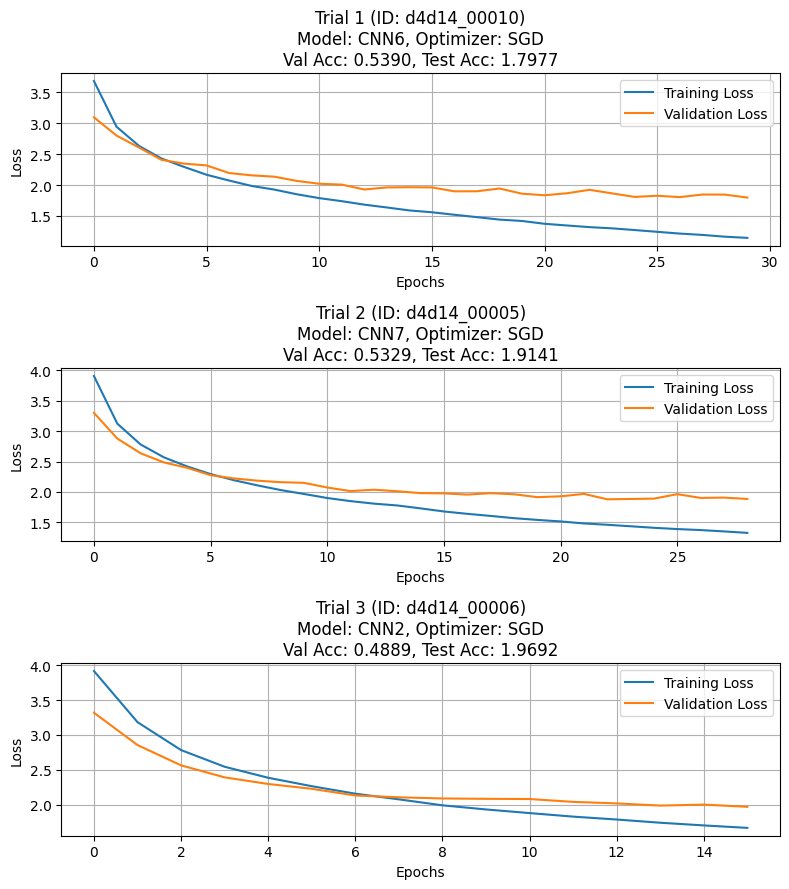

In [ ]:
from typing import Any, Tuple
from ray.tune import ExperimentAnalysis
import matplotlib.pyplot as plt
from ray.tune.experiment import Trial # To use as type 


def plot_top_n_trials(analysis: ExperimentAnalysis, n=3):
    '''This function is used to plot the best n model training and validation loss.'''
    models : List[Tuple[Trial, Dict[str, Any]]] = []
    # Get top n trials
    trials = sorted(analysis.trials, 
                   key=lambda t: t.last_result.get("accuracy", 0),
                   reverse=True)[:n]

    fig, axes = plt.subplots(n, 1, figsize=(8, 3*n))
    if n == 1:
        axes = [axes]

    for i, trial in enumerate(trials):
        checkpoint = analysis.get_best_checkpoint(trial=trial, 
                                                metric="accuracy",
                                                mode="max")
        if checkpoint is None:
            raise ValueError("No best checkpoint found.")
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl" 
            with open(data_path, "rb") as fp:
                checkpoint_data = pickle.load(fp)  # Load the data from the checkpoint
            models.append((trial, checkpoint_data)) # Save the model and the data
            val_loss = checkpoint_data["val_loss_array"] 
            train_loss = checkpoint_data["train_loss_array"]
            
            ### Plot the valdiaiton and training loss
            axes[i].plot(train_loss, label="Training Loss")
            axes[i].plot(val_loss, label="Validation Loss")
            axes[i].set_title(f'Trial {i+1} (ID: {trial.trial_id})\n'
                            f'Model: {trial.config["model"]}, '
                            f'Optimizer: {trial.config["optimizer"]}\n'
                            f'Val Acc: {trial.last_result["accuracy"]:.4f}, '
                            f'Test Acc: {trial.last_result["loss"]:.4f}')
            axes[i].set_xlabel('Epochs')
            axes[i].set_ylabel('Loss')
            axes[i].legend()
            axes[i].grid(True)

    plt.tight_layout()
    plt.show()
    return models
n_best_models = plot_top_n_trials(analysis, n=3)

In [ ]:
# Print the models information 
for t, d in n_best_models[:3]:
    print(f"Model: {t.config['model']}, Optimizer: {t.config['optimizer']}")
    print(f"Validation Loss: {d['val_loss_array'][-1]}")
    print(f"Training Loss: {d['train_loss_array'][-1]}")
    print(f"Validation Accuracy: {t.last_result['accuracy']}")
    print(f"The config: \n{pprint.pformat( t.config)} ")
    print("\n\n\n")

Model: CNN6, Optimizer: SGD
Validation Loss: 1.7977476119995117
Training Loss: 1.1461206627063454
Validation Accuracy: 0.539
The config: 
{'AdaGrad': {'initial_accumulator_value': 0.03316077306413725,
             'lr': 0.007107453370245861,
             'lr_decay': 0.019062534822198576},
 'Adam': {'B1': 0.9207197648609654,
          'B2': 0.9990600763157776,
          'lr': 0.0764421871749766},
 'RMSProp': {'alpha': 0.9502605903191053,
             'lr': 0.001611227663936158,
             'momentum': 0.17303264195642898},
 'SGD': {'dampening': 0.094655749224775,
         'lr': 0.004278943210433503,
         'momentum': 0.009581454091906229},
 'model': 'CNN6',
 'optimizer': 'SGD'} 




Model: CNN7, Optimizer: SGD
Validation Loss: 1.8854777812957764
Training Loss: 1.3287222212985157
Validation Accuracy: 0.5329
The config: 
{'AdaGrad': {'initial_accumulator_value': 0.16145121814432478,
             'lr': 0.006472057329034583,
             'lr_decay': 0.005153396051404347},
 'Adam': {'B1'

### Train the 3 selected models with the entire training set

In [ ]:
three_best_models = n_best_models[:3]  # get the 3 best models
training_loss_and_model: List[Tuple[List[float], nn.Module]] = []
# Train the best model for 100 epochs using the entire training set
for trial, checkpoint_data in three_best_models:
    print(f"\n\nTraining best model from trial {trial.trial_id}")
    # Train for 100 epochs
    train_loss_and_model = train_cifar(config=trial.config, max_epochs=100, all_training_data=trainset)
    if train_loss_and_model is None:
        raise ValueError("Training failed")
    train_loss, model = train_loss_and_model
    training_loss_and_model.append(train_loss_and_model)



Training best model from trial d4d14_00010
{'AdaGrad': {'initial_accumulator_value': 0.03316077306413725,
             'lr': 0.007107453370245861,
             'lr_decay': 0.019062534822198576},
 'Adam': {'B1': 0.9207197648609654,
          'B2': 0.9990600763157776,
          'lr': 0.0764421871749766},
 'RMSProp': {'alpha': 0.9502605903191053,
             'lr': 0.001611227663936158,
             'momentum': 0.17303264195642898},
 'SGD': {'dampening': 0.094655749224775,
         'lr': 0.004278943210433503,
         'momentum': 0.009581454091906229},
 'model': 'CNN6',
 'optimizer': 'SGD'}
Epoch: 0, avg_train_loss: 3.818044234275818
Epoch: 1, avg_train_loss: 3.302322732448578


Epoch: 2, avg_train_loss: 3.032740186691284
Epoch: 3, avg_train_loss: 2.839074227809906
Epoch: 4, avg_train_loss: 2.6917725687026977
Epoch: 5, avg_train_loss: 2.5853564224243164
Epoch: 6, avg_train_loss: 2.491364962100983
Epoch: 7, avg_train_loss: 2.4076141221523284
Epoch: 8, avg_train_loss: 2.345062045812607
Epoch: 9, avg_train_loss: 2.2829854345321654
Epoch: 10, avg_train_loss: 2.227891983747482
Epoch: 11, avg_train_loss: 2.188165769815445
Epoch: 12, avg_train_loss: 2.1376364057064055
Epoch: 13, avg_train_loss: 2.1006090850830077
Epoch: 14, avg_train_loss: 2.0625398569107056
Epoch: 15, avg_train_loss: 2.0269381546974183
Epoch: 16, avg_train_loss: 1.989978488445282
Epoch: 17, avg_train_loss: 1.9620910558700562
Epoch: 18, avg_train_loss: 1.9315875916481018
Epoch: 19, avg_train_loss: 1.90630739402771
Epoch: 20, avg_train_loss: 1.8760944457054138
Epoch: 21, avg_train_loss: 1.8486661219596863
Epoch: 22, avg_train_loss: 1.8287521922588348
Epoch: 23, avg_train_loss: 1.8033804788589478
Epoch

In [29]:
training_loss_and_model

[([3.818044234275818,
   3.302322732448578,
   3.032740186691284,
   2.839074227809906,
   2.6917725687026977,
   2.5853564224243164,
   2.491364962100983,
   2.4076141221523284,
   2.345062045812607,
   2.2829854345321654,
   2.227891983747482,
   2.188165769815445,
   2.1376364057064055,
   2.1006090850830077,
   2.0625398569107056,
   2.0269381546974183,
   1.989978488445282,
   1.9620910558700562,
   1.9315875916481018,
   1.90630739402771,
   1.8760944457054138,
   1.8486661219596863,
   1.8287521922588348,
   1.8033804788589478,
   1.7813083109855652,
   1.7538620960712432,
   1.7362488980293274,
   1.7183344252109527,
   1.6998246104717254,
   1.6781175615787507,
   1.6565380017757416,
   1.6499488434791565,
   1.6234271891117096,
   1.6075024755001068,
   1.5881952102184296,
   1.5745711324214935,
   1.5589175012111665,
   1.545486861228943,
   1.5319943461418153,
   1.5167500216960907,
   1.504699061870575,
   1.4885091028213502,
   1.4673528542518617,
   1.4596717612743377,
 

# Testing for Accuracy

In [30]:
for train_loss, net in training_loss_and_model:
    accuracy = test_accuracy(net)
    print(f"{net.__class__.__name__}  - Test accuracy: {accuracy:.4f}")

CNN6  - Test accuracy: 0.6012
CNN7  - Test accuracy: 0.6115
CNN2  - Test accuracy: 0.5876


### Accuracy results 

| Model | Test Accuracy |
|-------|--------------|
| CNN6  | 0.6012 |
| CNN7  | 0.6115 |
| CNN2  | 0.5876 |


# Benchmarking: Compare your model’s performance against others 

To compare these 3 best models, I used projects from papers
with code that focus on training a model only on CIFAR100.
The top 4 models found are

| Model                                                                 | Source | Accuracy (%) |
|----------------------------------------------------------------------|--------|--------------|
| CNN6                                                                  | HERE   | 60.12        |
| CNN7                                                                  | HERE   | 61.15        |
| CNN2                                                                  | HERE   | 58.76        |
| **Average (HERE)**                                                    |        | **60.01**    |
| EXACT: How to Train Your Accuracy                                     | Paper  | 82.68        |
| Differentiable Spike: Rethinking Gradient-Descent for Training Spiking Neural Networks | Paper  | 74.24        |
| Beta-Rank: A Robust Convolutional Filter Pruning Method For Imbalanced Medical Image Analysis | Paper  | 74.01        |
| Deep Residual Networks with Exponential Linear Unit                  | Paper  | 73.5         |
| **Average (Papers)**                                                  |        | **76.11**    |

The best projects from papers with code performed  about 16.1 percent better then the projects here

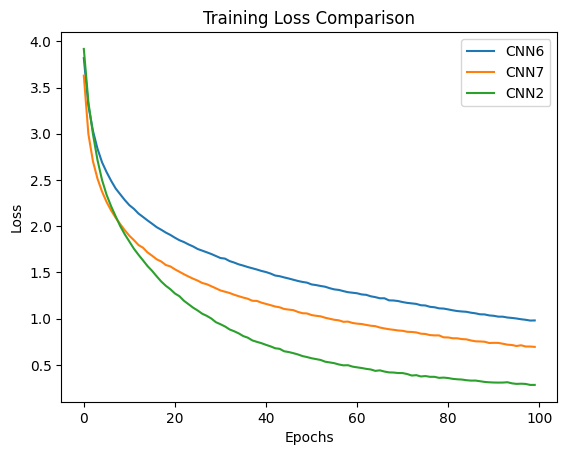

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")

for train_loss, net in training_loss_and_model:
    plt.plot(train_loss, label=net.__class__.__name__)

# Add legend and display
plt.legend()
plt.show()

Saving the models to be re-used

In [47]:
for train_loss, net in training_loss_and_model:
    # same the nets information so that is easier to replace the model in the future.
    torch.save(net.state_dict(), f"./models_trained/{net.__class__.__name__}.pt")
    print(f"Model {net.__class__.__name__} saved")

Model CNN6 saved
Model CNN7 saved
Model CNN2 saved


Printing the models information 

In [51]:
for train_loss, net in training_loss_and_model:
    print('\n\n' + "=" * 50)
    print(f"Model: {net.__class__.__name__}")
    print(net)
    
    # Calculate and print total parameters
    total_params = sum(p.numel() for p in net.parameters())
    trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Optional: Print detailed layer parameters
    print("\nDetailed layer parameters:")
    for name, param in net.named_parameters():
        print(f"{name}: {param.size()}")




Model: CNN6
CNN6(
  (layer1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(128, 246, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(246, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(246, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc): Linear(in_features=16384, out_features=100, bias=True)
)

Total parameters: 2,494,022
Trainable parameters: 2,494,022

Detailed layer parameters:
layer1.0.weight: torch.Size